# JAX and TF NCA Model Comparison with Pretrained Weights

---
#### This notebook validates JAX NCA Model with TF NCA Model using pretrained weights from Mordvintsev's NCA experiments.

> The aim of this notebook is to inspire the experimentation of JAX NCA Model on target images

## **Installations**

In [1]:
# !pip3 install jax
# !pip3 install jaxlib
# !pip3 install tensorflow
# !pip3 install numpy


## **Imports**

In [2]:
import jax
import jax.numpy as jnp
from jax import lax
import time
import random

import tensorflow as tf
from tensorflow.keras.layers import Conv2D
import numpy as np

## **Tensorflow/Keras Implementation of NCA Model**


In [3]:
def get_living_mask_tf(x):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

class CAModel(tf.keras.Model):

  def __init__(self, channel_n, fire_rate):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer())
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model


  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask_tf(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask_tf(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)

## **Pre-trained Model Initialization**

In [4]:
!wget -O models.zip 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/models.zip?raw=true'
!unzip -oq models.zip

EMOJI = '🦎😀💥👁🐠🦋🐞🕸🥨🎄'

def get_model(emoji='🦋', fire_rate=0.5, use_pool=1, damage_n=3, run=0,
              prefix='models/', output='model'):
  path = prefix
  assert fire_rate in [0.5, 1.0]
  if fire_rate==0.5:
    path += 'use_sample_pool_%d damage_n_%d '%(use_pool, damage_n)
  elif fire_rate==1.0:
    path += 'fire_rate_1.0 '
  code = hex(ord(emoji))[2:].upper()
  path += 'target_emoji_%s run_index_%d/08000'%(code, run)
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel(channel_n=16, fire_rate=fire_rate)
    ca.load_weights(path)
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

--2025-07-07 19:06:36--  https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/models.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/google-research/self-organising-systems/raw/refs/heads/master/assets/growing_ca/models.zip [following]
--2025-07-07 19:06:37--  https://github.com/google-research/self-organising-systems/raw/refs/heads/master/assets/growing_ca/models.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-research/self-organising-systems/refs/heads/master/assets/growing_ca/models.zip [following]
--2025-07-07 19:06:37--  https://raw.githubusercontent.com/google-research/self-organising-systems/refs/heads/master/assets/growing_ca/models.zip
Resolving raw.githubusercontent.com (raw.gi

In [5]:
# For Keras 3 compatability
!pip3 install "keras<3" "tensorflow<2.16"


In [6]:
pretrained_model = get_model(emoji='🦎')

# Prints weights and biases of pretrained_model
for layer in pretrained_model.layers:
    weights = layer.get_weights()
    print(layer.name, [w.shape for w in weights])

params = pretrained_model.layers[0].get_weights()
w1 = params[0]
b1 = params[1]
w2 = params[2]
b2 = params[3]

np.save('w1.npy', w1)
np.save('b1.npy', b1)
np.save('w2.npy', w2)
np.save('b2.npy', b2)


sequential [(1, 1, 48, 128), (128,), (1, 1, 128, 16), (16,)]


## **JAX Implementation of CA Model**

In [7]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

# CA Model and Utilities

def get_living_mask_jax(x):
  alpha = x[:, :, :, 3:4]
  return lax.reduce_window(
        alpha,
        -jnp.inf,
        lax.max,
        window_dimensions=(1, 3, 3, 1),
        window_strides=(1, 1, 1, 1),
        padding='SAME'
    ) > 0.1

# Load weights and biases
w1_jax = jnp.array(np.load('w1.npy'))
b1_jax = jnp.array(np.load('b1.npy'))
w2_jax = jnp.array(np.load('w2.npy'))
b2_jax = jnp.array(np.load('b2.npy'))

class CAModelJAX:
  # Modified version of __init__ to take in custom weights and biases
  def __init__(self, channel_n, fire_rate):
    self.channel_n = channel_n
    self.fire_rate = fire_rate

  # Depthwise Convolution
  def perceive(self, x, angle):
    identify = jnp.float32([0,1,0])
    identify = jnp.outer(identify, identify)
    dx = jnp.outer(jnp.array([1,2,1]),jnp.array([-1,0,1])) / 8.0
    dy = dx.T
    c, s = jnp.cos(angle), jnp.sin(angle)
    base_filters = jnp.stack([identify, c*dx-s*dy, s*dx+c*dy])
    kernel = jnp.zeros((3,3,1,self.channel_n*3))
    for i in range(self.channel_n):
      for j in range(3):
        kernel = kernel.at[:,:,0,i*3+j].set(base_filters[j])
    y = lax.conv_general_dilated(
          x, # shape: [1,3,3,16]
          kernel, # shape: [3,3,1,48]
          window_strides=(1, 1),
          padding="SAME",
          dimension_numbers=("NHWC", "HWIO", "NHWC"),
          feature_group_count=self.channel_n  # depthwise conv here
          )
    return y

  # Dense Layer Convolutions
  def __call__(self, key, x, angle=0.0, fire_rate=None, step_size=1.0):
    pre_life_mask = get_living_mask_jax(x)

    y = self.perceive(x, angle)  # output channels = channel_n * 3 (e.g., 48)
    y = lax.conv_general_dilated(y, w1_jax,
                                window_strides=(1,1),
                                padding='SAME',
                                dimension_numbers=("NHWC", "HWIO", "NHWC")) + b1_jax  # Normal conv, output channels=128
    y = jax.nn.relu(y)
    y = lax.conv_general_dilated(y, w2_jax,
                                window_strides=(1,1),
                                padding='SAME',
                                dimension_numbers=("NHWC", "HWIO", "NHWC")) + b2_jax
    y *= step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = jax.random.uniform(key, x[:,:,:,:1].shape) <= fire_rate
    x += y * jnp.astype(update_mask, jnp.float32)
    post_life_mask = get_living_mask_jax(x)
    life_mask = pre_life_mask & post_life_mask
    return x * jnp.astype(life_mask, jnp.float32)

## **Testing Output**

In [8]:
channel_n=16
fire_rate = 0.5

def make_seed_jax(size, n=1):
  x = np.zeros([n, size, size, channel_n], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return jnp.array(x)

def make_seed_tf(size, n=1):
  x = np.zeros([n, size, size, channel_n], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

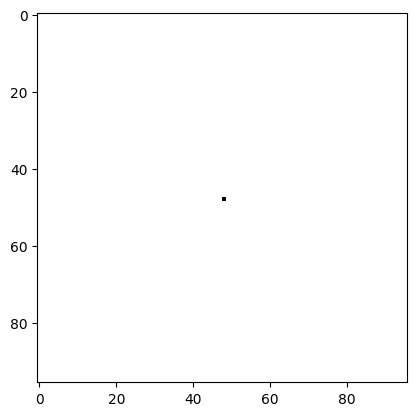

In [9]:
import matplotlib.pyplot as plt

seed = make_seed_jax(96)
plt.imshow(seed[0,:,:,:4])

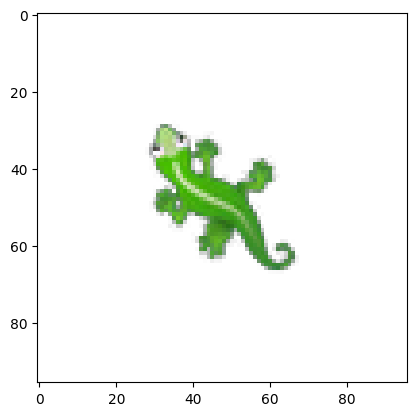

In [10]:
model_jax = CAModelJAX(channel_n, fire_rate)
x = seed
steps = 250

start_key = jax.random.PRNGKey(0)
for i in range(steps):
  key, subkey = jax.random.split(start_key, num=2)
  x = model_jax(subkey, x)
  start_key = key # Update the key for the next iteration

plt.imshow(x[0,:,:,:4])

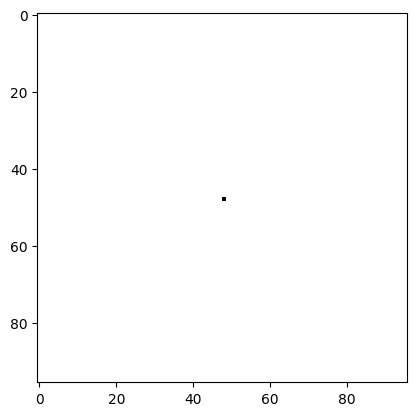

In [11]:
seed2 = make_seed_tf(96)
plt.imshow(seed2[0,:,:,:4])

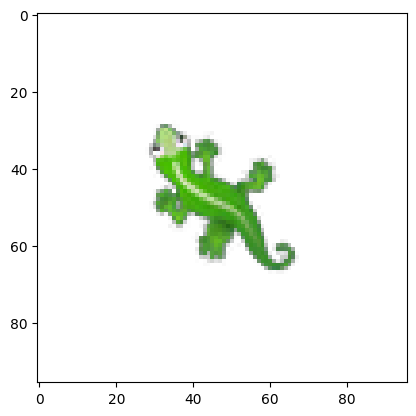

In [12]:
y = seed2

for i in range(steps):
  y = pretrained_model(y)

plt.imshow(y[0,:,:,:4])
